In [3]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from src.data.data_util import (
    pyramid_transform, 
    calculate_mean_std,
    loader_generator,
)
from src.data.masked_dataset import MaskedDataset
from src.config import get_parser

from src.models.stylist import Stylist
from src.models.generator import Generator
from src.models.discriminator import Discriminator
from src.render.mesh_renderer import MeshPointsRenderer
from src.utilities.util import grid_to_list
# itr = iter(loader)
# for i in range(len(loader)):
#     batch = next(itr)
#     print(i)

mean = 0.1834
std = 0.2670

In [4]:
config = get_parser().parse_args(args=[])

config.batch_size = 8# + 128
config.blueprint = 'blueprint_16_512.npz'
#config.blueprint = 'vezuvio255.npz'

#config.blueprint = 'blueprint_noise_1_512.npz'
config.data_blueprint_size = 128
config.data_blueprint_coarse =  128
config.data_patch_size = 128
config.lr_g = 0.01
config.log_mesh_interval = 1

# config.ker_size = 5
# config.stride = 1
# config.padd_size = 2
config.latent_size = 32

pts_ds = MaskedDataset(config)
pts_ds.points.shape

torch.Size([16, 3, 512, 512])


torch.Size([16, 3, 128, 128])

In [5]:
device = torch.device("cuda")
print(device)

pts =  pts_ds.points[:config.batch_size].to(device)
pts.shape

cuda


torch.Size([8, 3, 128, 128])

In [7]:
root = '/home/bobi/Desktop/db/ffhq-dataset/thumbnails'
ds = ImageFolder(root, transform=pyramid_transform(mean, std))
loader = DataLoader(ds, batch_size=config.batch_size, shuffle=True)
res = next(iter(loader))
res[0]['large'].shape, res[0]['medium'].shape, res[0]['small'].shape

(torch.Size([8, 1, 128, 128]),
 torch.Size([8, 1, 64, 64]),
 torch.Size([8, 1, 32, 32]))

In [8]:
ds.transform

<function src.data.data_util.pyramid_transform.<locals>.final_transform(img)>

In [38]:
stylist =  Stylist(config).to(device)
stylist

Stylist(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [39]:
generator = Generator(config).to(device)
generator

Generator(
  (head): ConvBlock(
    (conv): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (b1): GenBlock(
    (mod_conv): ModulateConvBlock(
      (style): DenseBlock(
        (fc): Linear(in_features=32, out_features=256, bias=False)
        (activate): Identity()
      )
      (activate): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv1): ConvBlock(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv2): ConvBlock(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

In [47]:
mesh_renderer = MeshPointsRenderer(config).to(device)
mesh_renderer.setup(device)   
mesh_renderer

MeshPointsRenderer(
  (vrt_nrm): VertexNormals: size: 128 path: ./data/trimap_128.pth
  (renderer): MeshRenderer(
    (rasterizer): MeshRasterizer(
      (cameras): FoVPerspectiveCameras()
    )
    (shader): SoftPhongShader(
      (lights): PointLights()
      (materials): Materials()
      (cameras): FoVPerspectiveCameras()
    )
  )
)

In [41]:
batch, _ = next(iter(loader))
image = batch['large'].to(device)
print(image.shape)
style = stylist(image)
print(style.shape)

pts = generator(pts, style)
pts.shape

torch.Size([8, 1, 128, 128])
torch.Size([8, 32])


torch.Size([8, 3, 128, 128])

In [75]:
images = mesh_renderer(grid_to_list(pts))
images = images[..., :3].mean(-1, keepdim=True).permute(0, 3, 1, 2)
print(images.shape)
images = (images - mean) / std
print(images.shape)

torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


In [ ]:
for batch_no, (batch, _) in enumerate(loader):
    image = batch['image'].to(device)
    style = stylist(image)
    

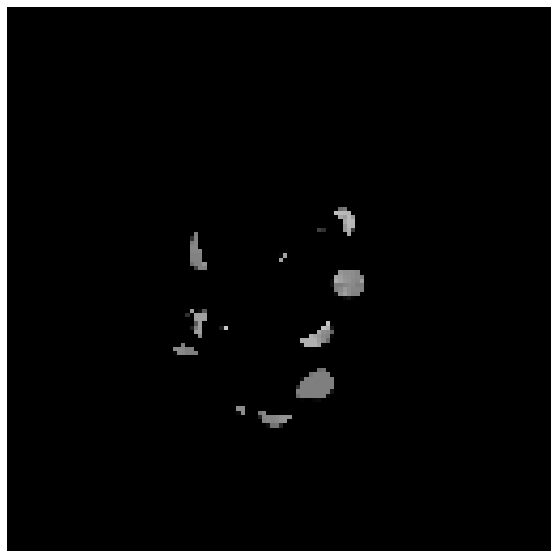

In [70]:
import matplotlib.pyplot as plt

images = mesh_renderer(grid_to_list(pts))
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].detach().cpu().numpy())
plt.grid("off");
plt.axis("off");


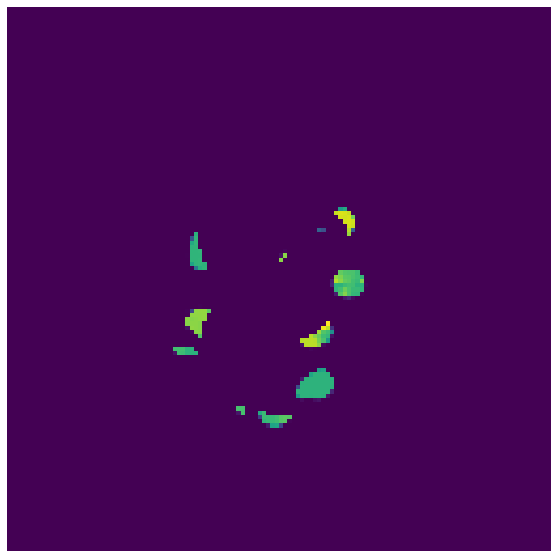

In [71]:
import matplotlib.pyplot as plt

images = mesh_renderer(grid_to_list(pts))
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].mean(-1).detach().cpu().numpy())
plt.grid("off");
plt.axis("off");